# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import RegexTokenizer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql import Window
from pyspark.sql.types import *
from pytz import timezone

import datetime
import pyspark.sql.functions as f
import numpy as np

In [2]:
# create a Spark session

spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Load dataset from .json file

stack_overflow_data = 'mini_sparkify_event_data.json'
df = spark.read.json(stack_overflow_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [6]:
# For testing: Possibly subset dataset to increase speed

# df=df.limit(100)

In [7]:
df.count()

286500

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# 1.) Defining churn

In [8]:
# Add column for churn event
# Churn event = "Cancellation Confirmation"
isChurnEvent=f.udf(lambda x: 1 if (x=="Cancellation Confirmation") else 0, IntegerType() )
df=df.withColumn("churn", isChurnEvent(df.page))

# Add column for churn users
# A churn user is a user which has at least one churn event
userWin=Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df=df.withColumn("churnUser", f.sum(df.churn).over(userWin))

# 2.) Understanding the meaning of the columns

## 1.) userId

In [9]:


df.groupby("userId").count().sort("userId").show(5)

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
|    10|  795|
|   100| 3214|
|100001|  187|
|100002|  218|
+------+-----+
only showing top 5 rows



8346 rows have an empty userID. As our analysis is user-based (i.e. we want to know which users will churn and which not),  these rows are not useful for us because we cannot identify single users from them. 
In the feature engineering part, these rows should be dropped. 

In [10]:
# which pages are visited by anonymous users?
df.select("page").filter(df.userId=="").dropDuplicates().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [11]:
df.filter((df.page=="Submit Registration") 
          |(df.page=="Login")
          |(df.page=="Register")).select(df.userId).dropDuplicates().show()

+------+
|userId|
+------+
|      |
+------+



Apparently, before Login/Registration, 
the userId is always unknown for the system and thus, an empty ID is written in the record.
-> as not-identifiable users (i.e. users which are not logged in) are not relevant for churn analysis, 
these users will be excluded from analysis

In [12]:
df=df.where(df.userId!="")

## 2.) artist

In [13]:
df.groupby("artist").count().sort("count", ascending=False).show(10, truncate=False)

+----------------------+-----+
|artist                |count|
+----------------------+-----+
|null                  |50046|
|Kings Of Leon         |1841 |
|Coldplay              |1813 |
|Florence + The Machine|1236 |
|Dwight Yoakam         |1135 |
|BjÃÂ¶rk              |1133 |
|The Black Keys        |1125 |
|Muse                  |1090 |
|Justin Bieber         |1044 |
|Jack Johnson          |1007 |
+----------------------+-----+
only showing top 10 rows



Many rows without an artist; probably, they represent technical pages (Login, Downgrade, ...)

## 3.) auth

Defines log-in status

In [14]:
df.select("auth").dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



## 4.) gender

In [15]:
df.groupby("gender").count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



## 5.) sessionId and 6.) itemInSession

ID of the session. itemInSession apparently is the counter of the action executed during active session

In [16]:
df.select("itemInSession").dropDuplicates().count()

1311

In [17]:
df.describe("itemInSession").show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|  129.851729399489|
|    min|                 0|
|    max|              1321|
+-------+------------------+



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002549C86F7F0>]],
      dtype=object)

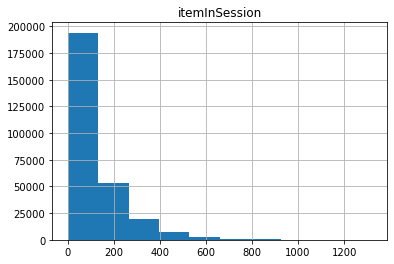

In [18]:
df.select("itemInSession").toPandas().hist()

## 7.) length: 
Is this the duration of the action?
Seems to be somehow normally distributed. No obvious dependency to sessionId or itemInSession

In [19]:
df.select("userId", "sessionId", "ts", "itemInSession", "length").where(df.userId != "").sort(["userId", "ts"]).show(20)

+------+---------+-------------+-------------+---------+
|userId|sessionId|           ts|itemInSession|   length|
+------+---------+-------------+-------------+---------+
|    10|        9|1538965220000|            0|265.53424|
|    10|        9|1538965485000|            1| 200.4371|
|    10|        9|1538965685000|            2|208.03873|
|    10|        9|1538965893000|            3|526.44526|
|    10|        9|1538966419000|            4|272.06485|
|    10|        9|1538966691000|            5|207.01995|
|    10|        9|1538966898000|            6|106.31791|
|    10|        9|1538966899000|            7|     null|
|    10|        9|1538967004000|            8| 239.3073|
|    10|        9|1538967243000|            9|264.85506|
|    10|        9|1538967507000|           10|363.41506|
|    10|        9|1538967508000|           11|     null|
|    10|        9|1538967509000|           12|     null|
|    10|        9|1538967870000|           13|240.01261|
|    10|        9|1538968110000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002549C890EB0>]],
      dtype=object)

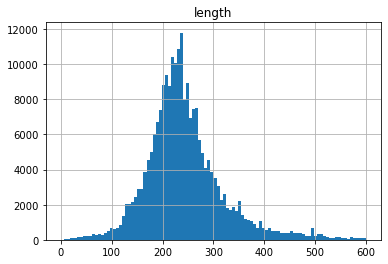

In [20]:
df.select("length").where(df.length<600).toPandas().hist(bins=100)

## 8.) level
Contains the information whether the action executed by a user is part of a subscription or free.
Apparently it's possible to be logged in, but not to pay.
In contrast, in order to have paid status, you MUST be logged in

In [21]:
df.groupby("level", "auth").count().show()

+-----+---------+------+
|level|     auth| count|
+-----+---------+------+
| paid|Cancelled|    31|
| free|Logged In| 55700|
| free|Cancelled|    21|
| paid|Logged In|222402|
+-----+---------+------+



## 9.) location
Location with city and state abbreviation

In [22]:
df.select("location").dropDuplicates().show(115, truncate=False)

+---------------------------------------------+
|location                                     |
+---------------------------------------------+
|Gainesville, FL                              |
|Atlantic City-Hammonton, NJ                  |
|Deltona-Daytona Beach-Ormond Beach, FL       |
|San Diego-Carlsbad, CA                       |
|Cleveland-Elyria, OH                         |
|Kingsport-Bristol-Bristol, TN-VA             |
|New Haven-Milford, CT                        |
|Birmingham-Hoover, AL                        |
|Corpus Christi, TX                           |
|Dubuque, IA                                  |
|Las Vegas-Henderson-Paradise, NV             |
|Indianapolis-Carmel-Anderson, IN             |
|Seattle-Tacoma-Bellevue, WA                  |
|Albany, OR                                   |
|Winston-Salem, NC                            |
|Bakersfield, CA                              |
|Los Angeles-Long Beach-Anaheim, CA           |
|Minneapolis-St. Paul-Bloomington, MN-WI

## 10.) method, 11.) page, 12.) status
Method: HTML command; depend on page

Page: Loaded page of the application

Status: HTTP status code

In [23]:
df.groupby("status").count().show()

+------+------+
|status| count|
+------+------+
|   307| 23184|
|   404|   252|
|   200|254718|
+------+------+



In [24]:
# Dependency between page, method and status

df.groupby("page", "method", "status").count().sort("page", "method", "status").show(100, truncate=False)

+-------------------------+------+------+------+
|page                     |method|status|count |
+-------------------------+------+------+------+
|About                    |GET   |200   |495   |
|Add Friend               |PUT   |307   |4277  |
|Add to Playlist          |PUT   |200   |6526  |
|Cancel                   |PUT   |307   |52    |
|Cancellation Confirmation|GET   |200   |52    |
|Downgrade                |GET   |200   |2055  |
|Error                    |GET   |404   |252   |
|Help                     |GET   |200   |1454  |
|Home                     |GET   |200   |10082 |
|Logout                   |PUT   |307   |3226  |
|NextSong                 |PUT   |200   |228108|
|Roll Advert              |GET   |200   |3933  |
|Save Settings            |PUT   |307   |310   |
|Settings                 |GET   |200   |1514  |
|Submit Downgrade         |PUT   |307   |63    |
|Submit Upgrade           |PUT   |307   |159   |
|Thumbs Down              |PUT   |307   |2546  |
|Thumbs Up          

The following cells show us that users sometimes continue to use the service after a "downgrade" event, so it cannot really be seen as churn. 
Thus we keep our definition of churn: Churn = access to page 'Cancellation Confirmation'

In [25]:
# Users who downgraded
df.select("userId").filter(df.page=="Downgrade").dropDuplicates().show(10)

+------+
|userId|
+------+
|200002|
|    51|
|   124|
|    54|
|    15|
|   155|
|   132|
|100014|
|   101|
|    11|
+------+
only showing top 10 rows



In [26]:
# Downgrading procedure for one example user
# Apparently, service is also used afterwards; so Downgrade doesn't automatically mean that the user leaves the service

df.select("userId", "sessionId", "ts", "page").where(df.userId=="51").sort("userId", "ts").show(3000)


+------+---------+-------------+--------------------+
|userId|sessionId|           ts|                page|
+------+---------+-------------+--------------------+
|    51|      236|1538398632000|                Home|
|    51|      236|1538398649000|            NextSong|
|    51|      236|1538398938000|            NextSong|
|    51|      236|1538399167000|            NextSong|
|    51|      236|1538399351000|            NextSong|
|    51|      236|1538399495000|            NextSong|
|    51|      236|1538399843000|            NextSong|
|    51|      236|1538400086000|            NextSong|
|    51|      236|1538400309000|            NextSong|
|    51|      236|1538400621000|            NextSong|
|    51|      236|1538400824000|            NextSong|
|    51|      236|1538400891000|     Add to Playlist|
|    51|      236|1538401249000|            NextSong|
|    51|      236|1538401459000|            NextSong|
|    51|      236|1538401460000|         Thumbs Down|
|    51|      236|1538401688

## 13.) registration

Each user seems to have exactly one unique registration

In [27]:
df.select("userId", "registration").dropDuplicates().groupby("userId").count().orderBy("count", ascending=False).show(5)

+------+-----+
|userId|count|
+------+-----+
|100010|    1|
|200002|    1|
|   125|    1|
|    51|    1|
|   124|    1|
+------+-----+
only showing top 5 rows



## 14.) song

In [28]:
df.select("song").dropDuplicates().count()

58481

In [29]:
df.groupby("song").count().orderBy("count", ascending=False).show(10, False)

+-------------------------------------------------------------------+-----+
|song                                                               |count|
+-------------------------------------------------------------------+-----+
|null                                                               |50046|
|You're The One                                                     |1153 |
|Undo                                                               |1026 |
|Revelry                                                            |854  |
|Sehr kosmisch                                                      |728  |
|Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)|641  |
|Dog Days Are Over (Radio Edit)                                     |574  |
|Secrets                                                            |466  |
|Use Somebody                                                       |459  |
|Canada                                                             |435  |
+-----------

## 15.) ts
Timestamp; lies between 01.10.2018 and 03.12.2018
i.e. 63 days are contained in the dataset

In [30]:
min_ts=df.agg(f.min("ts")).collect()[0][0]
max_ts=df.agg(f.max("ts")).collect()[0][0]

min_date = datetime.datetime.fromtimestamp(min_ts/1000.0)
max_date = datetime.datetime.fromtimestamp(max_ts/1000.0)
print(min_date.isoformat())
print(max_date.isoformat())

# Time range in days
date_range=max_date-min_date
print(date_range.days)

2018-10-01T02:01:57
2018-12-03T02:11:16
63


In [31]:
# Min. and max. day of year (in interval)
print(min_date.timetuple().tm_yday)
print(max_date.timetuple().tm_yday)

274
337


In [32]:
# ts: There are no N/A timestamps in dataset which need to be cleaned

In [33]:
df.select("ts").dropDuplicates().sort("ts", ascending=False).show(5)
df.select("ts").dropDuplicates().sort("ts", ascending=True).show(5)

+-------------+
|           ts|
+-------------+
|1543799476000|
|1543622579000|
|1543622432000|
|1543622411000|
|1543622398000|
+-------------+
only showing top 5 rows

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
|1538352394000|
|1538352416000|
|1538352676000|
+-------------+
only showing top 5 rows



## 16.) userAgent
Browser / OS of the user

In [34]:
df.groupby("userAgent").count().show(60, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------+-----+
|userAgent                                                                                                                                  |count|
+-------------------------------------------------------------------------------------------------------------------------------------------+-----+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                 |240  |
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                   |5238 |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                                 |62   |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Saf

In [35]:
df.select("userAgent").dropDuplicates().count()

56

# 3.) Analyzing correlations with churn event

## 3.1) Adding additional columns

In [36]:
# Operating system

def getOSOfStr(str1):
    if str1 == None:
        return np.NaN
    
    if "Mac OS" in str1: 
        return "Mac OS"
    elif "iPhone OS" in str1:
        return "iOS"
    elif "Windows NT 5.1" in str1:
        return "Windows XP"
    elif "Windows NT 6.0" in str1:
        return "Windows Vista"
    elif "Windows NT 6.1" in str1:
        return "Windows 7"
    elif "Windows NT 6.2" in str1:
        return "Windows 8"
    elif "Windows NT 6.3" in str1:
        return "Windows 8.1"
    elif "Ubuntu" in str1:
        return "Ubuntu"
    elif "Linux" in str1:
        return "Linux"
    else:
        return np.NaN

getOS=f.udf(lambda x: getOSOfStr(x), StringType())
df=df.withColumn("OS", getOS(df.userAgent))

In [37]:
# Browser

def getBrowserOfStr(str1):
    if str1 == None:
        return np.NaN
    
    if "Safari" in str1:
        if "Chrome" in str1:
            return "Chrome"
        else:
            return "Safari"
    elif "Firefox" in str1:
        return "Firefox"
    elif "Trident" in str1:
        return "Internet Explorer"
    else:
        return np.NaN
    
getBrowser=f.udf(lambda x: getBrowserOfStr(x), StringType())
df=df.withColumn("Browser", getBrowser(df.userAgent))

In [38]:
# State

def getStateOfStr(str1):
    if str1 == None:
        return np.NaN
    
    commaPos=str1.rindex(",")
    rightSubstr=str1[commaPos+1:]
    return rightSubstr.strip()

getState=f.udf(lambda x: getStateOfStr(x), StringType())
df=df.withColumn("State", getState(df.location))

In [39]:
# Drop duplicate users
df_users=df.dropDuplicates(["userId"])
df_users.cache().count()

225

In [40]:
# How many users churn?
df_users.groupby("churnUser").count().show()
# 52 churning users vs. 174 not-churning

+---------+-----+
|churnUser|count|
+---------+-----+
|        0|  173|
|        1|   52|
+---------+-----+



## 3.2) Plots

In the following section, we will analyze more in detail the correlations between the "Churn" feature to other characteristics of a user (which we will calculate from the original dataset).

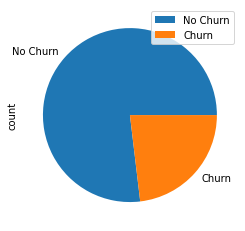

In [41]:
df_churns=df_users.groupby("churnUser").count().toPandas()
df_churns["label"]=np.where(df_churns["churnUser"]==0,"No Churn", "Churn")
df_churns.set_index(["label"]).plot(y="count", kind="pie")

#df_churns.show()

Obviously, the dataset is heavily imbalanced concerning the users which churn. We must take into account this when training the models (to avoid bias). 

+---------+------+-----+
|churnUser|gender|count|
+---------+------+-----+
|        0|     F|   84|
|        1|     M|   32|
|        1|     F|   20|
|        0|     M|   89|
+---------+------+-----+



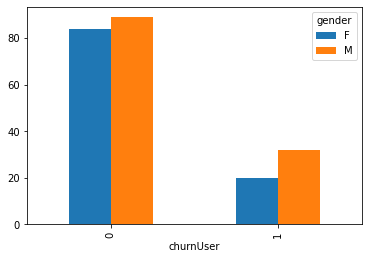

In [42]:
# Dependency between gender and churn
gender_counts=df_users.groupby("churnUser", "gender").count()
gender_counts.show()
gender_counts.toPandas().set_index(["churnUser", "gender"]).unstack().droplevel(0, axis=1).plot(kind="bar")

We see that churn rate is higher for male users.

+---------+-------------+-----+
|churnUser|           OS|count|
+---------+-------------+-----+
|        0|        Linux|    6|
|        1|        Linux|    1|
|        0|       Mac OS|   79|
|        1|       Mac OS|   23|
|        0|       Ubuntu|    1|
|        1|       Ubuntu|    4|
|        0|    Windows 7|   68|
|        1|    Windows 7|   17|
|        0|    Windows 8|    3|
|        1|    Windows 8|    1|
|        0|  Windows 8.1|   11|
|        1|  Windows 8.1|    5|
|        0|Windows Vista|    1|
|        0|   Windows XP|    4|
|        1|   Windows XP|    1|
+---------+-------------+-----+



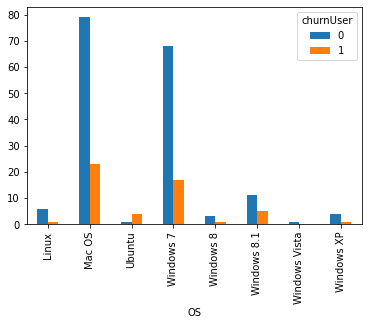

In [43]:
# Operating system

osCounts=df_users.groupby("churnUser", "OS").count().sort(["OS", "churnUser"])
osCounts.show()
osCounts.toPandas().set_index(["OS", "churnUser"]).unstack().droplevel(0, axis=1).plot(kind="bar")

In [44]:
osProportions=df_users.groupby("OS").avg("churnUser")
osProportions=osProportions.withColumnRenamed("avg(churnUser)", "churningUsers")
osProportions=osProportions.withColumn("notChurningUsers", 1-osProportions.churningUsers)
osProportions.show()

+-------------+-------------------+-------------------+
|           OS|      churningUsers|   notChurningUsers|
+-------------+-------------------+-------------------+
|    Windows 8|               0.25|               0.75|
|       Mac OS|0.22549019607843138| 0.7745098039215687|
|  Windows 8.1|             0.3125|             0.6875|
|        Linux|0.14285714285714285| 0.8571428571428572|
|Windows Vista|                0.0|                1.0|
|       Ubuntu|                0.8|0.19999999999999996|
|   Windows XP|                0.2|                0.8|
|    Windows 7|                0.2|                0.8|
+-------------+-------------------+-------------------+



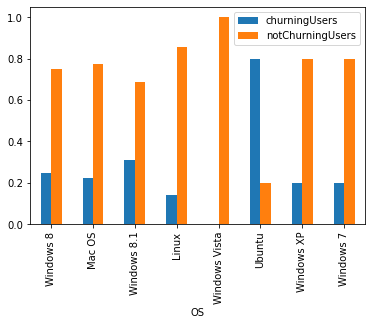

In [82]:
df1 = osProportions.toPandas().set_index(["OS"])
ax = df1.plot(kind="bar")

The difference in the churn/not-churn proportion (depending on the used OS system) is not obvious. 
Possible explanation: The implementation of the Sparkify service leads to different user experience on different operating systems. 

In [46]:
# Number of different users in the data frame
userCount=df.select("userId").dropDuplicates().count()
print("Number of different users in dataframe: ", userCount)
#Number of user-OS-combinations in dataframe
userOSCount=df.groupby("userId", "OS").count().count()
print("Number of user-OS-combinations in dataframe: ", userOSCount)
#Number of user-Browser-combinations in dataframe
userBrowserCount=df.groupby("userId", "Browser").count().count()
print("Number of user-Browser-combinations in dataframe: ", userBrowserCount)

#-> Numbers equal, i.e. every user uses always the same OS, every user uses always the same Browser

Number of different users in dataframe:  225
Number of user-OS-combinations in dataframe:  225
Number of user-Browser-combinations in dataframe:  225


+---------+-----------------+-----+
|churnUser|          Browser|count|
+---------+-----------------+-----+
|        0|           Chrome|   92|
|        1|           Chrome|   25|
|        0|          Firefox|   34|
|        1|          Firefox|   16|
|        0|Internet Explorer|   11|
|        1|Internet Explorer|    1|
|        0|           Safari|   36|
|        1|           Safari|   10|
+---------+-----------------+-----+



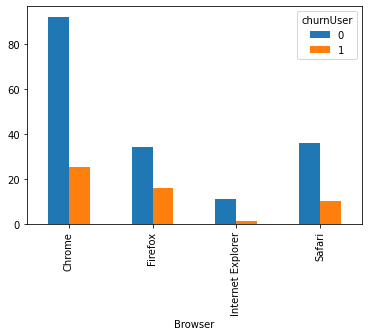

In [47]:
# Browser

browserCounts=df_users.groupby("churnUser", "Browser").count().sort(["Browser", "churnUser"])
browserCounts.show()
browserCounts.toPandas().set_index(["Browser", "churnUser"]).unstack().droplevel(0, axis=1).plot(kind="bar")

In [86]:
browserProportions=df_users.groupby("Browser").avg("churnUser")
browserProportions=browserProportions.withColumnRenamed("avg(churnUser)", "churningUsers")
browserProportions=browserProportions.withColumn("churningUsers", f.round("churningUsers", 2))
browserProportions=browserProportions.withColumn("notChurningUsers", f.round(1-browserProportions.churningUsers, 2))
browserProportions.show()

+-----------------+-------------+----------------+
|          Browser|churningUsers|notChurningUsers|
+-----------------+-------------+----------------+
|Internet Explorer|         0.08|            0.92|
|          Firefox|         0.32|            0.68|
|           Safari|         0.22|            0.78|
|           Chrome|         0.21|            0.79|
+-----------------+-------------+----------------+



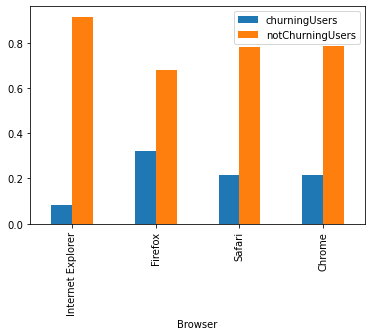

In [49]:
browserProportions.toPandas().set_index(["Browser"]).plot(kind="bar")

Similiarly to the OS system, the used browser might influence the user experience of Sparkify and thus lead to different churn rates. 
As consequence, we will include Browser / operating system as feature in the modelling phase. 

+---------+-----------+-----+
|churnUser|      State|count|
+---------+-----------+-----+
|        0|         AK|    2|
|        0|         AL|    2|
|        1|         AL|    2|
|        1|         AR|    1|
|        0|         AZ|    5|
|        1|         AZ|    2|
|        0|         CA|   27|
|        1|         CA|    6|
|        0|         CO|    2|
|        1|         CO|    2|
|        0|         CT|    7|
|        0|DC-VA-MD-WV|    3|
|        1|DC-VA-MD-WV|    1|
|        0|         FL|   11|
|        1|         FL|    3|
|        0|         GA|    4|
|        0|      GA-AL|    2|
|        0|         IA|    1|
|        0|         IL|    3|
|        0|   IL-IN-WI|    5|
+---------+-----------+-----+
only showing top 20 rows



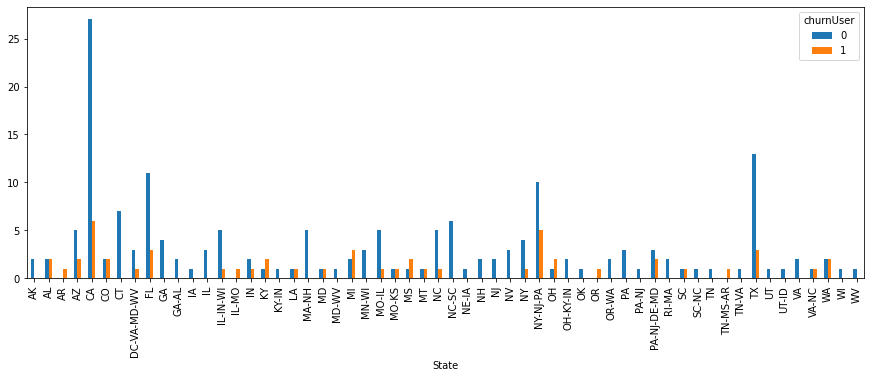

In [50]:
# State

stateCounts=df_users.groupby("churnUser", "State").count().sort(["State", "churnUser"])
stateCounts.show()
stateCounts.toPandas().set_index(["State", "churnUser"]).unstack().droplevel(0, axis=1).plot(kind="bar", figsize=(15,5))

In [51]:
stateProportions=df_users.groupby("State").agg({"churnUser":"avg", "*":"count"})
stateProportions=stateProportions.withColumnRenamed("count(1)", "userNumber")
stateProportions=stateProportions.where(stateProportions.userNumber>5)
stateProportions=stateProportions.withColumnRenamed("avg(churnUser)", "churningUsers")
stateProportions=stateProportions.withColumn("notChurningUsers", 1-stateProportions.churningUsers)
stateProportions.show()

+--------+----------+-------------------+------------------+
|   State|userNumber|      churningUsers|  notChurningUsers|
+--------+----------+-------------------+------------------+
|      AZ|         7| 0.2857142857142857|0.7142857142857143|
|NY-NJ-PA|        15| 0.3333333333333333|0.6666666666666667|
|      CA|        33|0.18181818181818182|0.8181818181818181|
|      CT|         7|                0.0|               1.0|
|      NC|         6|0.16666666666666666|0.8333333333333334|
|      TX|        16|             0.1875|            0.8125|
|IL-IN-WI|         6|0.16666666666666666|0.8333333333333334|
|   MO-IL|         6|0.16666666666666666|0.8333333333333334|
|      FL|        14|0.21428571428571427|0.7857142857142857|
|   NC-SC|         6|                0.0|               1.0|
+--------+----------+-------------------+------------------+



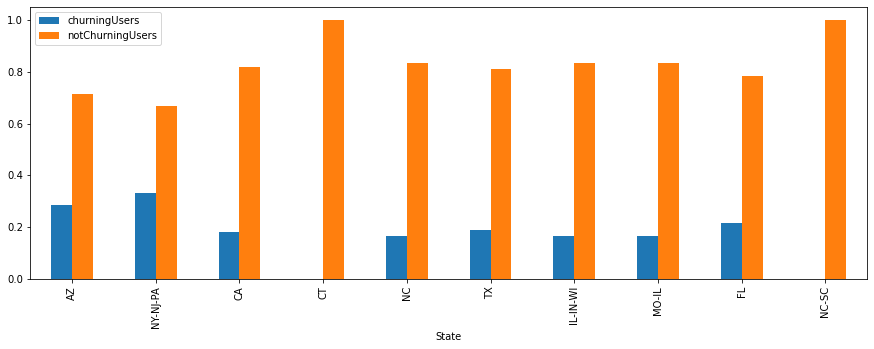

In [52]:
stateProportions.select("State", "churningUsers", "notChurningUsers").toPandas().set_index(["State"]).plot(kind="bar", figsize=(15,5))

Also when we calculate the churn rates per state, we see remarkable differences (above only plotted for states with more than 5 users in our dataset).
As consequence, also the state of a user will be taken into consideration in our modelling phase (as categorical feature).

In [53]:
# Churn event over time

Text(0, 0.5, 'Churns')

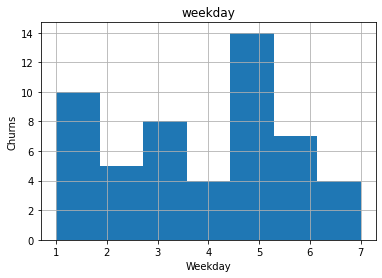

In [78]:
# Distribution of churn over week
convertToWeekday=f.udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).date().isoweekday(), IntegerType())
df=df.withColumn("weekday", convertToWeekday(df.ts))
df1=df.filter(df.churn==1).select("weekday").toPandas()
axs=df1.hist(bins=7)
axs[0][0].set_xlabel("Weekday")
axs[0][0].set_ylabel("Churns")

Text(0, 0.5, 'Churns')

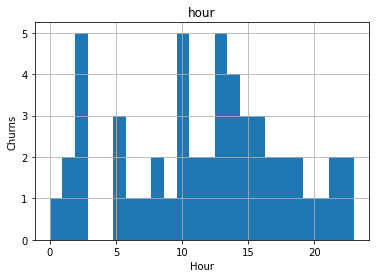

In [69]:
# Distribution of churn over day
ourTimezone="US/Central"
getHour=f.udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).astimezone(timezone(ourTimezone)).time().hour, IntegerType())
df=df.withColumn("hour", getHour(df.ts))
df1=df.filter(df.churn==1).select("hour").toPandas()
axs=df1.hist(bins=24)
axs[0][0].set_xlabel("Hour")
axs[0][0].set_ylabel("Churns")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002549EC7B5B0>]],
      dtype=object)

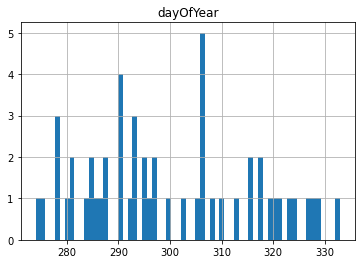

In [56]:
# Distribution of churn over year
getDayOfYear=f.udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).timetuple().tm_yday, IntegerType())
df=df.withColumn("dayOfYear", getDayOfYear(df.ts))
df.filter(df.churn==1).select("dayOfYear").toPandas().hist(bins=63)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000254A1B35B80>]],
      dtype=object)

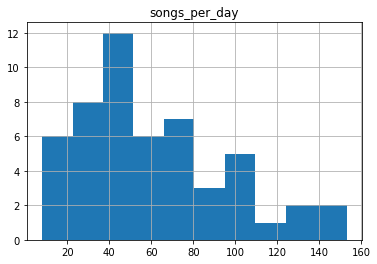

In [89]:
# Analyze average number of songs per day for churning users
songs_per_day=df.where((df.page=="NextSong") & (df.churnUser=="1")).groupby("userId", "dayOfYear").count().sort("userId", "dayOfYear")
songs_per_day_user=songs_per_day.groupby("userId").agg({"count": "avg"}).select("userId", f.round("avg(count)", 0).alias("songs_per_day"))
songs_per_day_user.select("songs_per_day").toPandas().hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002549FE12040>]],
      dtype=object)

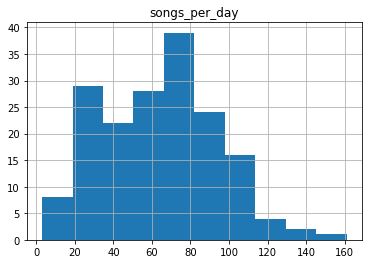

In [58]:
# Analyze average number of songs per day for non-churning users
songs_per_day=df.where((df.page=="NextSong") & (df.churnUser=="0")).groupby("userId", "dayOfYear").count().sort("userId", "dayOfYear")
songs_per_day_user=songs_per_day.groupby("userId").agg({"count": "avg"}).select("userId", f.round("avg(count)", 0).alias("songs_per_day"))
songs_per_day_user.select("songs_per_day").toPandas().hist()

From the two graphics above, it's obvious that the average number of listened songs per day is very different between users who churn and non-churning users. 
As consequence, the number of songs per day should be added as numerical feature to the feature set. 

Not only the statistical distribution of the song number seems different but also the full amount. This seems logic, due to the fact that churning users cannot access songs any more after having churned. 
To account for this fact, the song-per-day feature should only be calculated for the period before a churn event of a user.

In [59]:
df.count()

278154